In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import numpy as np

In [3]:
def reorganize_datastructure(eros1):
    """
    Sometimes we want the data in order of model[basin] rather than basin[model]
    :eros1: erosion rates exported from the model
    :exln: Length of the dataset (probably this part can be implicit... have not implemented this yet)
    
    :return: dfs, the basins in order of model [basin]
    
    """
    dfs = np.array([None]*len(eros1[1])) # Datasets organized as array[model][basin]
    c=0
    for i in range(len(dfs)): #Loop through each basin, reorganize
            dfs[i] = np.zeros(len(eros1))

            for k in range(len(eros1)):

                if eros1[k] is None:
                    continue
                dfs[i][k] = eros1[k][i]
                c+=1
    return dfs

In [4]:
folder = '../results//nz1//' #Example result

octopus_folder = '../example_data/nz_basins_/nz_basins_.shp'
a = gpd.read_file(octopus_folder)

#a.index=a['OBSID1']
ns = np.load('{}/ns.npy'.format(folder),allow_pickle=True)
ms = np.load('{}/ms.npy'.format(folder),allow_pickle=True)
diffus = np.load('{}/diffu.npy'.format(folder),allow_pickle=True)
eros1 = np.load('{}/eros.npy'.format(folder),allow_pickle=True)
#print(a.index)
eros1 = eros1[a.index]# Use index of octopus with deleted vars

careas = np.load('{}/careas.npy'.format(folder),allow_pickle=True)
slps2 = np.load('{}/slps2.npy'.format(folder),allow_pickle=True)
dns = np.load('{}/dns.npy'.format(folder),allow_pickle=True)

## Example calculating MAE for all values
dfs = reorganize_datastructure(eros1)


L=len(eros1[1])
mae_vals = np.zeros(L) #The MAE values
r2_vals = np.zeros(L)
intercepts = np.zeros(L)
coef_qmle  = np.zeros(L)

badvals = np.array([16,21,26])
for i in range(L):#
        
        if(np.all(dfs[i])==None):
            continue #In some cases there will be basins we are not using, so we skip them

        y = np.float64(a['ebe_mmkyr'.upper()]) / 1000 / 1000 # observed data in mm/yr
        y[badvals] = 0
        x = dfs[i] #Modeled data for run i


        #In a few cases there will be erosion rates that are 0 in either the modeled or real data which are NaN / inf
        I = np.where(x<=0)[0] 
        x=np.delete(x,I)
        y=np.delete(y,I)
        I2 = np.where(y<=0)[0]
        x = np.delete(x,I2)
        y = np.delete(y,I2)
        intercept1 = np.mean(np.log10(y) - np.log10(x)) #The mean of  the log transformed residuals
        y_est = np.log10(x) + intercept1
        ####
        coef_qmle[i] = np.sum((np.log(10**y_est) - np.log(y))**2)/(len(y)-1)
        intercepts[i] = intercept1
        
        mae_vals[i] = mae(np.log10(y.reshape(-1,1)),y_est.reshape(-1,1)) #Get the corcoefs
        r2_vals[i] = r2(np.log10(y.reshape(-1,1)),y_est.reshape(-1,1)) #Get the corcoefs



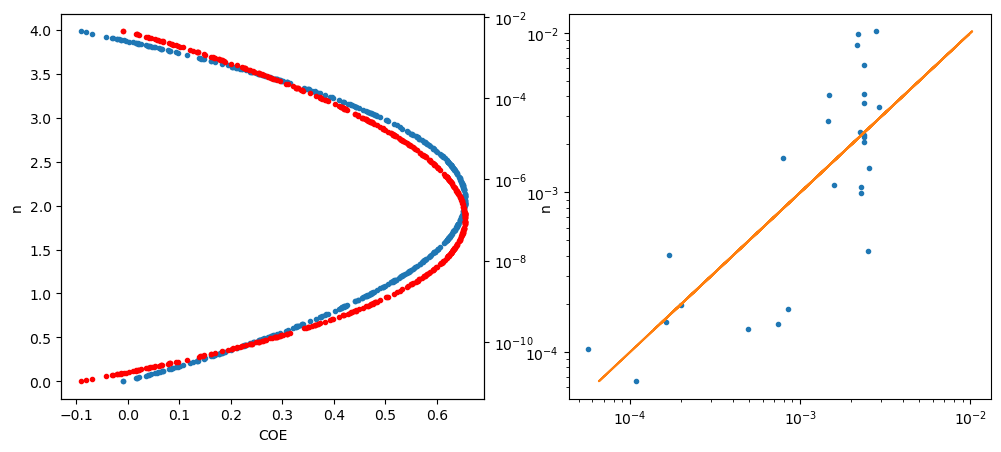

In [5]:
## Then plot
fig,ax = plt.subplots(1,2,figsize=(12,5))

plt.sca(ax[0])
plt.plot(r2_vals, ns, '.')
plt.ylabel('n')
plt.xlabel('COE')
ax[0].twinx()
ks =  10**(intercepts) * 1e-8 * np.exp(coef_qmle/2)
plt.plot(r2_vals, ks, '.r')
plt.ylabel('n')
plt.xlabel('COE')
plt.yscale('log')


plt.sca(ax[1])
plt.plot(dfs[np.argmin(mae_vals)] *10**(intercepts[np.argmin(mae_vals)]) ,a['EBE_MMKYR']/1e6,'.')
plt.plot(a['EBE_MMKYR']/1e6, a['EBE_MMKYR']/1e6)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('')
plt.xlabel('')
plt.show(block=True)



In [45]:
ks[np.argmax(r2_vals)]

1.1188946896085144e-07